## Retrieval augmented generation
 
In [retrieval augmented generation](https://www.pinecone.io/learn/retrieval-augmented-generation/) (RAG), an LLM utilized context of documents retrieved from an external data source as part of its execution. 

This approach is used in many applications where we would like to:  
– have up do date context  
– ground model in our domain and specific knowledge base (e.g., our PDFs, a set of videos, etc) instead of using its learned knowledge  
– reduce hallucinations and make answers of our interest more factual

Note that RAG is not always necessary.  
When you ask an openai model to help you with a certain task (think of a spellchecking) you don't strictly need to get a source for the generated text.  
You can rely on model's general "intelligence" and English grammar capabilities.

However, in business environment, companies are responsible for what their GenAI systems produce as output, thus it's necessary to back up the knowledge of LLM with a factually correct data.

Here are the core components of a RAG system:

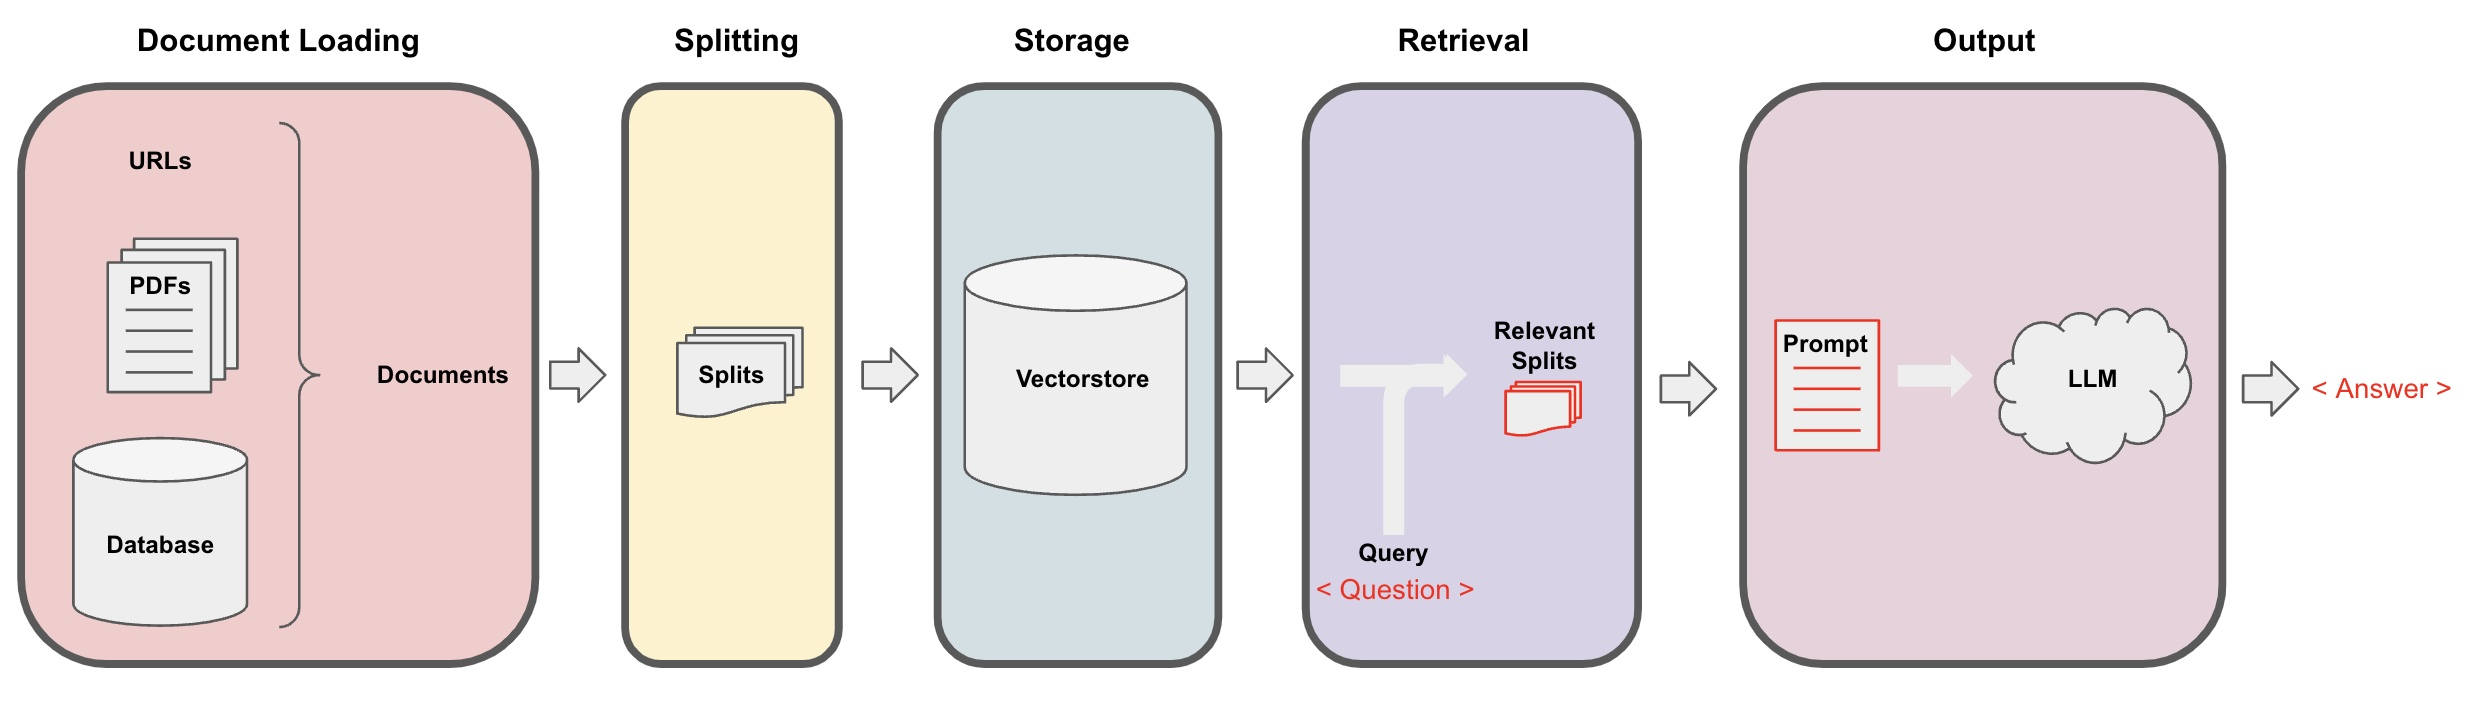

In this Notebook we will go other all the main components of a Retrieval Augmented Generation flow:
- Document Loading
- Splitting data into chunks
- Encoding these chunks
- Storing them in the Vector data base
- Retrieving chunks given a query
- Finally generating an answer based on retrieved context.

There are many variations and architectural aspects of such system.  
This Notebook is aimed at making you familiar with main concepts and steps, existing tooling and abstractions of Langchain. 

We will touch this topic in the Notebook 3 of this module, as well as dive deeper into modeling and evaluation side of such system in the last module, covering search.

# Document Loading

In [1]:
import sys
from pathlib import Path
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv()) # read local .env file where azure openai credentials are stored


# path to the directory with PDFs
DOCS_DIR = Path.cwd() / "docs/cs229_lectures"
DOCS_DIR

WindowsPath('C:/Users/maksy/OneDrive/Desktop/module2_llm_intro/nlp-course/Module_2_LLM_basics/docs/cs229_lectures')

## Loading PDFs

Langchain [provides many pre-built loaders](https://python.langchain.com/docs/integrations/document_loaders/) to process various types of content.  
Each loader implements [BaseLoader](https://python.langchain.com/api_reference/core/document_loaders/langchain_core.document_loaders.base.BaseLoader.html) interface and has `.load` method which returns list of [Documents](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html#langchain_core.documents.base.Document). 

In reality this step usually involves custom logic for parsing and cleaning the data, here let's just use PyPDFLoader to read the PDFs.

In [2]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(DOCS_DIR / "MachineLearning-Lecture01.pdf")
pages = loader.load()

Each page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [3]:
len(pages)

22

In [4]:
page = pages[0]

In [5]:
print(page.page_content[0:1400])

MachineLearning-Lecture01  
Instructor (Andrew Ng): Okay. Good morning. Welcome to CS229, the machine 
learning class. So what I wanna do today is just spend a little time going over the logistics 
of the class, and then we'll start to talk a bit about machine learning.  
By way of introduction, my name's Andrew Ng and I'll be instructor for this class. And so 
I personally work in machine learning, and I've worked on it for about 15 years now, and 
I actually think that machine learning is the most exciting field of all the computer 
sciences. So I'm actually always excited about teaching this class. Sometimes I actually 
think that machine learning is not only the most exciting thing in computer science, but 
the most exciting thing in all of human endeavor, so maybe a little bias there.  
I also want to introduce the TAs, who are all graduate students doing research in or 
related to the machine learning and all aspects of machine learning. Paul Baumstarck 
works in machine learning

In [6]:
page.metadata

{'producer': 'Acrobat Distiller 8.1.0 (Windows)',
 'creator': 'PScript5.dll Version 5.2.2',
 'creationdate': '2008-07-11T11:25:23-07:00',
 'author': '',
 'moddate': '2008-07-11T11:25:23-07:00',
 'title': '',
 'source': 'C:\\Users\\maksy\\OneDrive\\Desktop\\module2_llm_intro\\nlp-course\\Module_2_LLM_basics\\docs\\cs229_lectures\\MachineLearning-Lecture01.pdf',
 'total_pages': 22,
 'page': 0,
 'page_label': '1'}

# Document Splitting

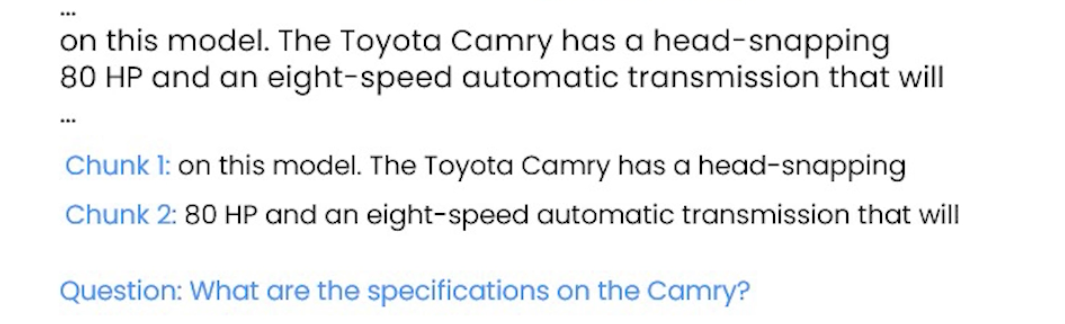

In [7]:
chunk_size = 26 # defines size of separate chunks in characters (by default; generally is defined with `length_function` passed to init)
chunk_overlap = 4 # number of overlapping characters

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter 

In [9]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

Both [`RecursiveCharacterTextSplitter`](https://python.langchain.com/docs/how_to/recursive_text_splitter/) and [`CharacterTextSplitter`](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.CharacterTextSplitter.html) look at characters when splitting text.  

However `RecursiveCharacterTextSplitter` attempts to do that in a more optimal manner.

Let's see how both of them work

As text example let's take English alphabet

And try to split it

As you can see, there is only one chunk, because the string contains only 26 characters which equals to our `chunk_size`.

Let's add some more characters

In [10]:
text2 = 'abcdefghijklmnopqrstuvwxyzabcdefg'

In [11]:
r_splitter.split_text(text2)

['abcdefghijklmnopqrstuvwxyz', 'wxyzabcdefg']

In [12]:
text3 = "a b c d e f g h i j k l m n o p q r s t u v w x y z"

By default, `CharacterTextSplitter` splits by double newlines, and if there are no newlines in the text it won't split it.

We need to specify the separator (here - whitespace symbol):

## Recursive splitting details

`RecursiveCharacterTextSplitter` is recommended for generic text. 

In [13]:
some_text = """When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentences. Similar ideas are in paragraphs. Paragraphs form a document. \n\n Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space. And words are separated by space."""
some_text

'When writing documents, writers will use document structure to group content. This can convey to the reader, which idea\'s are related. For example, closely related ideas are in sentences. Similar ideas are in paragraphs. Paragraphs form a document. \n\n Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space. And words are separated by space.'

In [14]:
len(some_text)

496

The `RecursiveCharacterTextSplitter` above utilizes a parameter called `separators`.  
The overall splitting strategy is  
1. Split text by the first separator in the provided `separators` list (`\n\n`) by default  
2. Collect chunks that fit into `chunk_size`. If sequential chunks fit, concatenate them.  
3. For chunks that do not fit, apply step 1 with the next separator from the `separator` list (single line breaks (`\n`), then spaces (` `), and finally any character)
4. Continue this process till the whole text is split into chunks.  

[See more detailed explanation here](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846)

`CharacterTextSplitter` splits in the middle of the sentence, while `RecursiveCharacterTextSplitter` splits into smaller chunks (below our `chunk_size`), but more meaningful ones.

We can also use `CharacterTextSplitter` to split the the document we loaded earlier.

Here we use `.split_documents` method which will split each document and return chunks with the original metadata.

In [15]:
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
)

In [16]:
docs = text_splitter.split_documents(pages)

In [17]:
docs[0], docs[1]

(Document(metadata={'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2008-07-11T11:25:23-07:00', 'author': '', 'moddate': '2008-07-11T11:25:23-07:00', 'title': '', 'source': 'C:\\Users\\maksy\\OneDrive\\Desktop\\module2_llm_intro\\nlp-course\\Module_2_LLM_basics\\docs\\cs229_lectures\\MachineLearning-Lecture01.pdf', 'total_pages': 22, 'page': 0, 'page_label': '1'}, page_content="MachineLearning-Lecture01  \nInstructor (Andrew Ng): Okay. Good morning. Welcome to CS229, the machine \nlearning class. So what I wanna do today is just spend a little time going over the logistics \nof the class, and then we'll start to talk a bit about machine learning.  \nBy way of introduction, my name's Andrew Ng and I'll be instructor for this class. And so \nI personally work in machine learning, and I've worked on it for about 15 years now, and \nI actually think that machine learning is the most exciting field of all the computer \nsciences. So

In [18]:
len(pages)

22

In [19]:
from langchain_text_splitters import TokenTextSplitter

In [20]:
text1 = "foo bar bazzyfoo"

In [21]:
text_splitter.split_text(text1)

['foo bar bazzyfoo']

In [22]:
docs = text_splitter.split_documents(pages)

## Context aware splitting

Chunking aims to keep text with common context together.

A text splitting often uses sentences or other delimiters to keep related text together but many documents (such as Markdown) have structure (headers) that can be explicitly used in splitting.

We can use [`MarkdownHeaderTextSplitter`](https://python.langchain.com/docs/how_to/markdown_header_metadata_splitter/) to preserve header metadata in our chunks, as show below.

In [23]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

markdown_document = """# Title\n\n \
## Chapter 1\n\n \
Hi this is Jim\n\n Hi this is Joe\n\n \
### Section \n\n \
Hi this is Lance \n\n 
## Chapter 2\n\n \
Hi this is Molly"""

We specify what header levels are to be used for splitting and give them name

In [24]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

In [25]:
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)
md_header_splits = markdown_splitter.split_text(markdown_document)

In [26]:
md_header_splits[1]

Document(metadata={'Header 1': 'Title', 'Header 2': 'Chapter 1', 'Header 3': 'Section'}, page_content='Hi this is Lance')

This may help you to preserve the internal structure of the document if it is initially in markdown format.   
This may be useful when you need to parse some Knowledge bases or Confluence pages.  
Also note, that some OCR engines, e.g. Azure Document Intelligence can provide you with Markdown output for your documents, which in combination with this splitter may give you more structured information inside your chunks.

[You can find other pre-build options here](https://python.langchain.com/docs/concepts/text_splitters/#document-structured-based)

We split our documents into small chunks, and now we need to put these chunks into an index, whereby we can easily retrieve them when we need to answer questions about this corpus of data.

We will use `RecursiveCharacterTextSplitter`

In [27]:
splits = text_splitter.split_documents(docs)

In [28]:
splits[0]

Document(metadata={'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2008-07-11T11:25:23-07:00', 'author': '', 'moddate': '2008-07-11T11:25:23-07:00', 'title': '', 'source': 'C:\\Users\\maksy\\OneDrive\\Desktop\\module2_llm_intro\\nlp-course\\Module_2_LLM_basics\\docs\\cs229_lectures\\MachineLearning-Lecture01.pdf', 'total_pages': 22, 'page': 0, 'page_label': '1'}, page_content="MachineLearning-Lecture01  \nInstructor (Andrew Ng): Okay. Good morning. Welcome to CS229, the machine \nlearning class. So what I wanna do today is just spend a little time going over the logistics \nof the class, and then we'll start to talk a bit about machine learning.  \nBy way of introduction, my name's Andrew Ng and I'll be instructor for this class. And so \nI personally work in machine learning, and I've worked on it for about 15 years now, and \nI actually think that machine learning is the most exciting field of all the computer \nsciences. So 

## Embeddings

Let's take our splits and embed them.

Embeddings are numeric vectors that represent real-world objects, like words, images, or videos, in a form that machine learning models can easily process.  

Such transformations from objects to vectors are *learned*, this is a separate ML task called `similarity` or `metric` learning. This transformation may be implemented as simple as a lookup table and as complex as an extraction of a vector from an LLM.

The goal of entity embeddings is to capture the characteristics of the entity as well as the relationships between different entities.

We will cover this topic in more details later in the course.

Note that embedding architectures preserve the concept of semantic similarity by inferring it as the distance between two points in vector space.  

This allows us to actually do the search and given an encoded (or embedded) `query` retrieve `similar` or `relevant` vectors which correspond to our chunks.

As mentioned above, selection, evaluation or implementation of a high-quality embedding model (encoder) is a task on itself.  
For the purposes of this module, we will utilize pre-trained OpenAI model available as a remote endpoint.

In [29]:
from langchain_openai import OpenAIEmbeddings

# initialize client
embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

In [30]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [31]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [32]:
# encode queries
embedding1 = embeddings_model.embed_query(sentence1)
embedding2 = embeddings_model.embed_query(sentence2)
embedding3 = embeddings_model.embed_query(sentence3)

In [33]:
import numpy as np

In [34]:
len(embedding1)

1536

Distance between vectors may be measured in different ways.  
For example it might depend on how the model was trained (what loss function was used), if the embeddings are normalized.   

[See here specifically for open ai embeddings](https://platform.openai.com/docs/guides/embeddings#which-distance-function-should-i-use)

As you can see above, vectors are normalized, which means cosine similarity converts into dot product.


As dogs and canines are closely semantically related concepts, their embeddings are relatively similar.

In [35]:
np.dot(embedding2, embedding3)

0.18497956745910826

## Vectorstores

In [36]:
from langchain_chroma import Chroma

In [37]:
persist_directory = 'docs/chroma_db'

In [38]:
len(splits)

78

In [39]:
# this will embed our split and create a search index with them in the DB
vectordb = Chroma.from_documents(
    collection_name="ml_lectures",
    documents=splits,
    embedding=embeddings_model,
    persist_directory=persist_directory
)

### Similarity Search

Vector database support various implementations of the search algorithm itself (different types of search indexes).

We will get back to this later in the course, an important thing to remember here is that choice of a certain configuration is always a trade-off between accuracy and speed of retrieval.

In [40]:
question = "is there an email i can ask for help"

In [41]:
docs = vectordb.similarity_search(question, k=3)

In [42]:
docs[0].page_content

"newsgroup that's sort of a forum for people in the class to get to know each other and \nhave whatever discussions you want to have amongst yourselves. So the class newsgroup \nwill not be monitored by the TAs and me. But this is a place for you to form study groups \nor find project partners or discuss homework problems and so on, and it's not monitored \nby the TAs and me. So feel free to talk trash about this class there.  \nIf you want to contact the teaching staff, please use the email address written down here, \ncs229-qa@cs.stanford.edu. This goes to an account that's read by all the TAs and me. So \nrather than sending us email individually, if you send email to this account, it will \nactually let us get back to you maximally quickly with answers to your questions.  \nIf you're asking questions about homework problems, please say in the subject line which \nassignment and which question the email refers to, since that will also help us to route"

## Edge cases

This seems great, and basic similarity search will get you 80% of the way there very easily. 

But there are some failure cases that can creep up. 

Here are some edge cases that can arise - we'll address them later.

In [43]:
docs = vectordb.similarity_search(question,k=5)

In [44]:
docs[0].page_content

"newsgroup that's sort of a forum for people in the class to get to know each other and \nhave whatever discussions you want to have amongst yourselves. So the class newsgroup \nwill not be monitored by the TAs and me. But this is a place for you to form study groups \nor find project partners or discuss homework problems and so on, and it's not monitored \nby the TAs and me. So feel free to talk trash about this class there.  \nIf you want to contact the teaching staff, please use the email address written down here, \ncs229-qa@cs.stanford.edu. This goes to an account that's read by all the TAs and me. So \nrather than sending us email individually, if you send email to this account, it will \nactually let us get back to you maximally quickly with answers to your questions.  \nIf you're asking questions about homework problems, please say in the subject line which \nassignment and which question the email refers to, since that will also help us to route"

We can see a new type of failure.

The question below asks a question about the third lecture, but includes results from other lectures as well.

In [45]:
docs = vectordb.similarity_search(question,k=5)

Let's find how we can deal with these issues.

Maximal Marginal Relevance (MMR) is a method used in information retrieval to select documents that are both relevant to the query and diverse with respect to the previously selected documents. This approach helps in reducing redundancy and increasing the coverage of different aspects of the query in the selected documents.

#### MMR Formula

The formula for MMR is:

$$
\text{MMR}(D_i) = \arg\max_{D_i \in R \setminus S} \left[ \lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j) \right]
$$

#### Explanation

- **$\text{MMR}(D_i)$**: Maximal Marginal Relevance score for document $D_i$.
- **$\arg\max$**: Argument of the maximum value.
- **$D_i \in R \setminus S$**: Candidate documents that are in the set $R$ (all documents) but not in the set $S$ (selected documents).
- **$\lambda$ (lambda)**: Trade-off parameter between relevance and diversity (0 ≤ $\lambda$ ≤ 1).
- **$\text{Sim}(D_i, Q)$**: Similarity between document $D_i$ and the query $Q$.
- **$\max_{D_j \in S} \text{Sim}(D_i, D_j)$**: Maximum similarity between document $D_i$ and any document $D_j$ in the selected set $S$.

#### Steps

1. **Compute Relevance Score**: $\text{Sim}(D_i, Q)$ for each candidate document $D_i$ with respect to the query $Q$.
2. **Compute Diversity Score**: $\max_{D_j \in S} \text{Sim}(D_i, D_j)$ for each candidate document $D_i$ with respect to the selected documents $S$.
3. **Calculate MMR Score**: $\lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j)$.
4. **Select Document**: Choose the document $D_i$ with the highest MMR score and add it to the selected set $S$.

In [46]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [47]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

Without using MMR both chunks contain almost the same wording and bear the same information.


Whereas with MMR chunks cover the topic more broadly.

In [48]:
vectordb = Chroma(
    collection_name="ml_lectures",
    persist_directory=persist_directory,
    embedding_function=embeddings_model
)

In [49]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question, k=3)

In [50]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLAB or in Octave, which is sort of — I \nknow some people c'

In [51]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [52]:
docs_mmr[1].page_content[:100]

"MATLAB, but it's free, and for the purposes of this class, it will work for just about \neverything. "

### Addressing Specificity: working with metadata

In the section on edge cases, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

For example, here we can filter documents by their names.

In [53]:
for d in docs:
    print(d.metadata)

{'author': '', 'creationdate': '2008-07-11T11:25:23-07:00', 'creator': 'PScript5.dll Version 5.2.2', 'moddate': '2008-07-11T11:25:23-07:00', 'page': 5, 'page_label': '6', 'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'source': 'C:\\Users\\maksy\\OneDrive\\Desktop\\module2_llm_intro\\nlp-course\\Module_2_LLM_basics\\docs\\cs229_lectures\\MachineLearning-Lecture01.pdf', 'title': '', 'total_pages': 22}
{'author': '', 'creationdate': '2008-07-11T11:25:23-07:00', 'creator': 'PScript5.dll Version 5.2.2', 'moddate': '2008-07-11T11:25:23-07:00', 'page': 5, 'page_label': '6', 'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'source': 'C:\\Users\\maksy\\OneDrive\\Desktop\\module2_llm_intro\\nlp-course\\Module_2_LLM_basics\\docs\\cs229_lectures\\MachineLearning-Lecture01.pdf', 'title': '', 'total_pages': 22}
{'author': '', 'creationdate': '2008-07-11T11:25:23-07:00', 'creator': 'PScript5.dll Version 5.2.2', 'moddate': '2008-07-11T11:25:23-07:00', 'page': 5, 'page_label': '6', 'producer': 'Acro

# Task

Now it is time for you to combine knowledge from the first notebook with what we have covered here and implement a chain that answers questions based on the DocBank dataset.

1. Create a custom document loader and implement `lazy_load` method that will accept path to a directory containing JSON files for an article, use function `process_article` from [parser.py](src/parser.py) to extract text and metadata and return list of `langchain_core.documents.Document` instances.

     See example: [How to create a custom Document Loader](https://python.langchain.com/docs/how_to/document_loader_custom/)

2. Upload the documents to the Chroma DB.

3. Create a custom retriever and implement `_get_relevant_documents` method that will accept `query_filter` and use it to call `similarity_search` of the Chroma DB.

     See example: [How to create a custom Retriever](https://python.langchain.com/docs/how_to/custom_retriever/)

4. Write a function that will accept a question and a document name, use the document name to filter the search and return an answer from LLM based on the information found in this document.

Use the same embeddings model as above

Specify paths to Chroma state and the dataset location

In [54]:
import sys
from pathlib import Path

# Add the src directory to sys.path
SRC_DIR = Path.cwd().parent / "Module_2_LLM_basics" / "src"
sys.path.append(str(SRC_DIR))

# Import the ArticleLoader class
from loader import ArticleLoader

# Correct the path to the dataset directory
JSON_DIR = Path.cwd().parent / "dataset_doc" / "train"

# Validate that the directory exists:
if not JSON_DIR.exists():
    raise FileNotFoundError(f"The dataset directory does not exist: {JSON_DIR}")

# Load small subset of articles to save money and time on encoding 
articles_list = ['1401.0616', '1401.0223', '1401.6145', '1401.6341', '1401.6354'] 

documents = []

for article_path in articles_list:
    article_dir = JSON_DIR / article_path
    if not article_dir.exists():
        raise FileNotFoundError(f"The article directory does not exist: {article_dir}")

    loader = ArticleLoader(article_dir)
    docs = loader.load()
    documents.extend(docs)

In [55]:
documents[0].metadata.keys()

dict_keys(['source', <Labels.AUTHOR: 'author'>, <Labels.ABSTRACT: 'abstract'>, <Labels.TITLE: 'title'>, 'page'])

In [56]:
import sys
from pathlib import Path

# Add the src directory to sys.path
SRC_DIR = Path.cwd() / "src"
sys.path.append(str(SRC_DIR))

# Import the ArticleRetriever class
from retriever import ArticleRetriever

# Initialize vector database
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings_model,
    collection_name="docbank_articles",
    persist_directory=persist_directory
)

# Create retriever
retriever = ArticleRetriever(vectordb)

In [57]:
from langchain_openai import ChatOpenAI

# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-4",  # Use the correct model name for chat models
    temperature=0,            
)

def qna_chain(query: str, document_name: str = None) -> str:
    """
    Retrieve documents relevant to the query, filter by document_name if provided,
    and generate an answer using the LLM.
    """
    # Retrieve documents
    query_filter = {"source": document_name} if document_name else None
    relevant_docs = retriever.get_relevant_documents(query=query, query_filter=query_filter)

    # Handle case where no relevant documents are found
    if not relevant_docs:
        return "That's beyond the scope of my knowledge."

    # Format context
    context = "\n\n".join(doc.page_content for doc in relevant_docs)

    # Preprocess context to remove irrelevant content
    filtered_context = "\n\n".join(
        line for line in context.splitlines() if line.strip() and not line.startswith("##") and "Noname manuscript" not in line
    )

    if not filtered_context.strip():
        return "That's beyond the scope of my knowledge."

    # Create prompt
    prompt = f"""Answer the question based only on the following context:
{filtered_context}

If the context does not contain the answer, reply exactly with: "That's beyond the scope of my knowledge". Do not add any other text.

Question: {query}

Answer:"""

    # Generate answer
    response = llm.invoke(prompt)  # Use the invoke method for chat models
    return response.content.strip()  # Access the content attribute and strip it

In [58]:
query = "What are mixed finite element methods?"
document = "1401.0616"

qna_chain(query=query, document_name=document)

'Mixed finite element methods are a generalisation of staggered finite difference methods, intended to address the problem of spurious pressure mode(s) observed in the finite difference A-grid and also observed in finite element methods when the same finite element method, different finite element spaces are selected for different variables. They are known variously as compatible finite elements, mimetic finite elements, discrete differential forms or finite element exterior calculus. These methods have the important property that differential operators such as grad and curl map from one finite element space; these embedding properties lead to discrete versions of the div-curl and curl-grad identities of vector calculus. This generalisation of the C-grid method allows use of arbitrary grids, with no requirement of orthogonal grids, without loss of consistency/convergence rate; extra flexibility in the choice of discretisation to optimize the ratio between global velocity degrees of fre

In [59]:
query = "Tell me about the latest iPhone"
document = "1401.0616"
qna_chain(query=query, document_name=document)

"That's beyond the scope of my knowledge"